# A Rate-Based Model of Neural Activity-Dependent Homeostatic Plasticity

###Goals/Objectives/Questions:

[***Correlation structure***] It is hypothesized that the relative numbers of ion channels embedded in the membrane of neurons maintained by activity-dependent homeostatic plasticity (ADHP) is related to the proportion in which they are inserted in response to hypo- or hyper-activity (ADHP mechanism details). However, these correlation structures could more readily be explained by the degeneracy of neural parameter space -- the fact that multiple ion channel configurations can produce the same average activity levels. Therefore, we aim to show that the same correlation structures can be produced regardless of ADHP mechanism details. This would support the explanation that it is instead a consequence of parameter space degeneracy.

###Main Inpsiration Paper(s):
Caplan, J. S., Williams, A. H., & Marder, E. (2014). Many parameter sets in a multicompartment model oscillator are robust to temperature perturbations. The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, 34(14), 4963–4975. https://doi.org/10.1523/JNEUROSCI.0280-14.2014

O’Leary, T., Williams, A. H., Caplan, J. S., & Marder, E. (2013). Correlations in ion channel expression emerge from homeostatic tuning rules. Proceedings of the National Academy of Sciences, 110(28). https://doi.org/10.1073/pnas.1309966110

Santin, J. M., & Schulz, D. J. (2019). Membrane Voltage Is a Direct Feedback Signal That Influences Correlated Ion Channel Expression in Neurons. Current Biology, 29(10), 1683-1688.e2. Scopus. https://doi.org/10.1016/j.cub.2019.04.008

Schulz, D. J., Goaillard, J.-M., & Marder, E. (2006). Variable channel expression in identified single and electrically coupled neurons in different animals. Nature Neuroscience, 9(3), Article 3. https://doi.org/10.1038/nn1639

Temporal, S., Desai, M., Khorkova, O., Varghese, G., Dai, A., Schulz, D. J., & Golowasch, J. (2012). Neuromodulation independently determines correlated channel expression and conductance levels in motor neurons of the stomatogastric ganglion. Journal of Neurophysiology, 107(2), 718–727. https://doi.org/10.1152/jn.00622.2011

Temporal, S., Lett, K. M., & Schulz, D. J. (2014). Activity-dependent feedback regulates correlated ion channel mRNA levels in single identified motor neurons. Current Biology: CB, 24(16), 1899–1904. https://doi.org/10.1016/j.cub.2014.06.067

In [3]:
#extraneous output is suppressed with -q
!pip install -q tellurium
!pip install -q ipympl

     -------------------------------------- 510.3/510.3 kB 5.4 MB/s eta 0:00:00


In [7]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

**Step 1**: Recreate individual timeseries from Figure 1

In [ ]:
model = '''
R1: -> Vm ; (g1*(E1-Vm) + g2*(E2-Vm) + g3*(E3-Vm)) / Cm
R2: -> Ca ; (A*(e^(b*Vm)) - Ca) / TauCa
R3: -> g1 ; g1*(Ca - Ct) / Tau1
R4: -> g2 ; g2*(Ca - Ct) / Tau2
R5: -> g3 ; g3*(Ca - Ct) / Tau3

e = 2.7182818284                            #Euler's number

g1 = 100; g2 = 20; g3 = 10;            # conductances uS/nF
E1 = -90; E2 = -30; E3 = 50;           # corresponding reversal potentials
A = 109.2                              # uM (from experimental fitting)
b = .08                                # mV^-1 (from experiment fitting)
Ca = 0.2;                              # calcium concentration
Vm = -50;                              # membrane potential
Ct = 1;                                # (uM) target 
Cm = 1;                                # Membrane capacitance
Tau1 = 4000;
Tau2 = -6000;
Tau3 = -1000;
TauCa = 100;                           #ms
'''

r = te.loada(model)

In [ ]:
r.reset()
result = r.simulate(0,3000,30000)
r.plot()
print('end [Ca]:',result[-1,-1])

Generic Python Model to double-check

In [ ]:
#original tau's (blue in figure)

t = 0
dt = .01
totalSimSteps = 500000
dataoriginal = np.zeros((5,totalSimSteps))             #Tau1 = 4000, Tau2 = -6000, Tau3 = -1000      
#initial values
Vm = -70
Ca = .2
g1 = 100
g2 = 20
g3 = 10

#parameter values 
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

for i in range(totalSimSteps):
  Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
  Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
  g1 += dt*(g1*(Ca - Ct) / Tau1)
  g2 += dt*(g2*(Ca - Ct) / Tau2)
  g3 += dt*(g3*(Ca - Ct) / Tau3)
  dataoriginal[:,i] = np.array([Ca,Vm,g1,g2,g3])
  t += dt

dataoriginal = np.vstack((np.arange(0,totalSimSteps), dataoriginal))
#print(dataoriginal)
#plt.plot(dataoriginal[0,:],dataoriginal[1,:],label = "Ca")
#plt.plot(dataoriginal[0,:],dataoriginal[2,:],label='Vm')
plt.plot(dataoriginal[0,:],dataoriginal[3,:]/1000,color='tab:blue')
plt.ylim([.04,.1])
plt.title('Original g1')
plt.show()
plt.plot(dataoriginal[0,:],dataoriginal[4,:]/1000,label='g2',color='tab:blue')
plt.ylim([0,.06])
plt.title('Original g2')
plt.show()
plt.plot(dataoriginal[0,:],dataoriginal[5,:]/1000,label='g3',color='tab:blue')
plt.ylim([0,.02])
plt.title('Original g3')
plt.show()

print('final [Ca]',dataoriginal[1,-1])
print('final Vm', dataoriginal[2,-1])

In [ ]:
#Scaled tau's (green in figure)

t = 0
dt = .001
totalSimSteps = 5000000     
datascaled = np.zeros((5,totalSimSteps))                 #Tau1 = 4000, Tau2 = -6000/10, Tau3 = -1000/40   
#initial values
Vm = -50
Ca = .2
g1 = 105
g2 = 20
g3 = 10

#parameter values 
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000/10
Tau3 = -1000/40
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

for i in range(totalSimSteps):
  Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
  Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
  g1 += dt*(g1*(Ca - Ct) / Tau1)
  g2 += dt*(g2*(Ca - Ct) / Tau2)
  g3 += dt*(g3*(Ca - Ct) / Tau3)
  datascaled[:,i] = np.array([Ca,Vm,g1,g2,g3])
  t += dt

datascaled = np.vstack((np.arange(0,totalSimSteps), datascaled))
#print(datascaled)
#plt.plot(datascaled[0,:],datascaled[1,:],label = "Ca")
#plt.plot(datascaled[0,:],datascaled[2,:],label='Vm')
plt.plot(datascaled[0,:],datascaled[3,:]/1000,label='g1',color='green')
plt.title('Scaled g1')
plt.show()
plt.plot(datascaled[0,:],datascaled[4,:]/1000,label='g2',color='green')
plt.title('Scaled g2')
plt.show()
plt.plot(datascaled[0,:],datascaled[5,:]/1000,label='g3',color='green')
plt.title('Scaled g3')
plt.show()

print('final [Ca]',datascaled[1,-1])
print('final Vm', datascaled[2,-1])

In [ ]:
#Flipped tau's (red in figure)

t = 0
dt = .01
totalSimSteps = 500000  
dataflipped = np.zeros((5,totalSimSteps))               #Tau1 = 4000, Tau2 = +6000, Tau3 = -1000   
#initial values
Vm = -70
Ca = .2
g1 = 105
g2 = 20
g3 = 10

#parameter values 
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = 6000  #FLIPPED SIGN
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

for i in range(totalSimSteps):
  Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
  Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
  g1 += dt*(g1*(Ca - Ct) / Tau1)
  g2 += dt*(g2*(Ca - Ct) / Tau2)
  g3 += dt*(g3*(Ca - Ct) / Tau3)
  dataflipped[:,i] = np.array([Ca,Vm,g1,g2,g3])
  t += dt

dataflipped = np.vstack((np.arange(0,totalSimSteps), dataflipped))
#print(dataflipped)
#plt.plot(dataflipped[0,:],dataflipped[1,:],label = "Ca")
#plt.plot(dataflipped[0,:],dataflipped[2,:],label='Vm')
plt.plot(dataflipped[0,:],dataflipped[3,:]/1000,label='g1',color = 'red')
plt.title('Flipped g1')
plt.show()
plt.plot(dataflipped[0,:],dataflipped[4,:]/1000,label='g2',color = 'red')
plt.title('Flipped g2')
plt.show()
plt.plot(dataflipped[0,:],dataflipped[5,:]/1000,label='g3',color = 'red')
plt.title('Flipped g3')
plt.show()

print('final [Ca]',dataflipped[1,-1])
print('final Vm', dataflipped[2,-1])

**Step 2**: Test from a small cluster of initial conditions (replicate paper)

**Step 3**: Test from a wide variety of initial conditions (Extend paper)

In [33]:
t = 0
dt = .01
totalSimSteps = 300000
numRandomStartPoints = 10
# ---------------- Original Runs --------------------
dataoriginal = np.zeros((5,totalSimSteps))             #Tau1 = 4000, Tau2 = -6000, Tau3 = -1000      
#initial values
Vm = -70
Ca = .2
centerg1 = 105
centerg2 = 20
centerg3 = 10

#parameter values original
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

startingPoints = np.zeros((3,numRandomStartPoints))
endingPointsOriginal = np.zeros((3,numRandomStartPoints))
for i in range(numRandomStartPoints):
  Vm = -70
  Ca = .2
  g1 = np.random.normal(centerg1 , 2.5)
  g2 = np.random.normal(centerg2 , 2.5)
  g3 = np.random.normal(centerg3 , 2.5)
  startingPoints[:,i] = np.array([g1,g2,g3])
  for j in range(totalSimSteps):
    Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
    Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
    g1 += dt*(g1*(Ca - Ct) / Tau1)
    g2 += dt*(g2*(Ca - Ct) / Tau2)
    g3 += dt*(g3*(Ca - Ct) / Tau3)
    dataoriginal[:,j] = np.array([Ca,Vm,g1,g2,g3])
    t += dt

  endingPointsOriginal[:,i] = np.array([g1,g2,g3])

dataoriginal = np.vstack((np.arange(0,totalSimSteps), dataoriginal))
# ---------------- Flipped Runs --------------------
#initial values flipped
Vm = -70
Ca = .2
centerg1 = 105
centerg2 = 20
centerg3 = 10

#parameter values flipped
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = 6000  #FLIPPED SIGN
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

dataFlipped = np.zeros((5,totalSimSteps))
endingPointsFlipped = np.zeros((3,numRandomStartPoints))
for i in range(numRandomStartPoints):
  Vm = -70
  Ca = .2
  g1 = np.random.normal(centerg1 , 2.5)
  g2 = np.random.normal(centerg2 , 2.5)
  g3 = np.random.normal(centerg3 , 2.5)
  startingPoints[:,i] = np.array([g1,g2,g3])
  for j in range(totalSimSteps):
    Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
    Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
    g1 += dt*(g1*(Ca - Ct) / Tau1)
    g2 += dt*(g2*(Ca - Ct) / Tau2)
    g3 += dt*(g3*(Ca - Ct) / Tau3)
    dataFlipped[:,j] = np.array([Ca,Vm,g1,g2,g3])
    t += dt

  endingPointsFlipped[:,i] = np.array([g1,g2,g3])

dataFlipped = np.vstack((np.arange(0,totalSimSteps), dataFlipped))

# ---------------- Scaled Runs --------------------
#initial values scaled
centerg1 = 105
centerg2 = 20
centerg3 = 10

#parameter values scaled
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000/10
Tau3 = -1000/40
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

dataScaled = np.zeros((5,totalSimSteps)) 
endingPointsScaled = np.zeros((3,numRandomStartPoints))
for i in range(numRandomStartPoints):
  Vm = -50
  Ca = .2
  g1 = np.random.normal(centerg1 , 2.5)
  g2 = np.random.normal(centerg2 , 2.5)
  g3 = np.random.normal(centerg3 , 2.5)
  startingPoints[:,i] = np.array([g1,g2,g3])
  for j in range(totalSimSteps):
    Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
    Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
    g1 += dt*(g1*(Ca - Ct) / Tau1)
    g2 += dt*(g2*(Ca - Ct) / Tau2)
    g3 += dt*(g3*(Ca - Ct) / Tau3)
    dataScaled[:,j] = np.array([Ca,Vm,g1,g2,g3])
    t += dt
  endingPointsScaled[:,i] = np.array([g1,g2,g3])
dataScaled = np.vstack((np.arange(0,totalSimSteps), dataScaled))


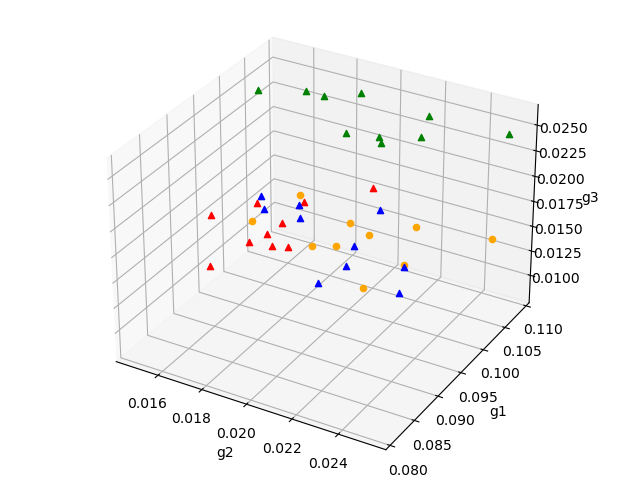

In [35]:
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)

for i in range(len(startingPoints[0,:])):
    startpts = ax.scatter(startingPoints[1,i]/1000, startingPoints[0,i]/1000, startingPoints[2,i]/1000, marker='o', color='orange') # orange for starting point
    og = ax.scatter(endingPointsOriginal[1,i]/1000, endingPointsOriginal[0,i]/1000, endingPointsOriginal[2,i]/1000, marker='^', color='blue')        # blue for original
    scale = ax.scatter(endingPointsScaled[1,i]/1000, endingPointsScaled[0,i]/1000, endingPointsScaled[2,i]/1000, marker='^', color='green')        # green for scaled
    flip = ax.scatter(endingPointsFlipped[1,i]/1000, endingPointsFlipped[0,i]/1000, endingPointsFlipped[2,i]/1000, marker='^', color='red')        # red for flipped

ax.set_xlabel('g2')
ax.set_ylabel('g1')
ax.set_zlabel('g3')

plt.show()

**Step 4**: Analyze and contrast correlation structure in both cases

Replicate paper's method of analyzing this (bottom of figure 1). Ideally, replicate their results when using thier small subset of initial points, but show that it breaks down with more initial points

*New questions to ask:*
*   Time-series level:

> * Oscillations in green???
*   Are there initial conditions (especially in the flipped/anti-homeostatic case) where a steady state is not reached (or all conductances go to zero)? I expect this to be the case when more initial conditions are considered

*   Parameter space level:

> * Noise in the system-> stable results? (Glazier's suggestion)
*What are the trajectories through parameter space? (Glazier's suggestion)
*Map basin of attraction of $Ca^{2+}$ steady state

*  Tau level:

> * Identify sets of taus that do and do not converge (as they observed in the article)


